In [1]:
import numpy as np
import matplotlib.pyplot as pl
import pandas as pd

In [2]:
# unzip and load dataset 
from zipfile import ZipFile
zipFile = ZipFile("assignment1-Dataset.zip", 'r')
zipFile.extractall()
train_data = np.load("Assignment1-Dataset/train_data.npy", encoding='bytes')
train_label = np.load("Assignment1-Dataset/train_label.npy", encoding='bytes')
test_data = np.load("Assignment1-Dataset/test_data.npy", encoding='bytes')
test_label = np.load("Assignment1-Dataset/test_label.npy", encoding='bytes')
# column-wise stack 
train_dataset = np.hstack([train_data, train_label])
test_dataset = np.hstack([test_data, test_label])
test_dataset

array([[-3.47967057e+00,  9.06426369e-01,  1.25195572e+00, ...,
         6.31729322e-01,  2.60908392e-01,  3.00000000e+00],
       [ 9.94315784e+00, -9.58055259e+00,  5.06857801e+00, ...,
        -3.18574521e-01, -2.67055346e-01,  8.00000000e+00],
       [ 4.70429957e+00, -8.83720616e+00,  4.10928532e+00, ...,
         2.65140024e-01,  1.67865616e-01,  8.00000000e+00],
       ...,
       [-1.52911933e+01,  2.50308666e+00, -2.27169405e-01, ...,
        -6.99688324e-02, -6.08919845e-01,  5.00000000e+00],
       [-5.85707877e+00,  2.04437491e+00,  3.65488937e+00, ...,
         6.86344933e-03,  2.01131653e-02,  1.00000000e+00],
       [-1.76542944e+00, -1.89117258e+00, -2.14885246e+00, ...,
         1.87276097e-02,  2.38587672e-01,  7.00000000e+00]])

# Data Preprocessing

In [3]:
def check_missing_data(dataset):
    """
    This function is used to check missing data.
    Parameters: 
        :type dataset: np.array
        :param dataset: column concatenation of data and labels
    Returns: boolean value indicating whether there is NaN in dataset
    """
    return np.isnan(np.sum(dataset))
print(check_missing_data(train_dataset))
print(check_missing_data(test_dataset))

False
False


## Standardize

In [4]:
class Standard_scaler(object):
    def __init__(self):
        """
        Perform standardisation on the onject, 
        transfroming to standard normal distribution(mean=0, variance = 1).
        Parameters: 
        :type mu: float
        :param mu: mean of input

        :type std: float
        :param std: standard deviation of input
        """
        self.mu = 0
        self.std = 0
    def transform(self, X):
        """
        For known mean and std, transform another dataset.
        eg. use train dataset mu and sd to standardise test data
        """
        return (X - self.mu) / self.std
    
    def fit_transform(self, X):
        self.mu = np.mean(X, axis=0)
        self.std = np.std(X, axis=0)
        return self.transform(X)
        

In [5]:
scaler = Standard_scaler()
x_train_norm = scaler.fit_transform(train_data)
x_test_norm =  scaler.transform(test_data)

## Activation

In [6]:
class Activation(object):
    def __init__(self,activation='relu'):
        """
         Activation layer of a MLP: 
         contains activation function to add nonlinearity.
         Parameters: 
             :type: input_v: np.array
             :param: input_v: input array, usually the output from previous layer
             
             :type: output_v: np.array
             :param output_v: output array after activation
        """
        self.input_v = None
        self.output_v = None
        
        # initialize activation function and its derivative
        if activation == 'logistic':
            self.f = self.__logistic
            self.f_deriv = self.__logistic_deriv
        elif activation == 'tanh':
            self.f = self.__tanh
            self.f_deriv = self.__tanh_deriv
        elif activation == 'relu':
            self.f = self.__relu
            self.f_deriv = self.__relu_deriv
        elif activation == 'softmax':
            self.f = self.__softmax
            self.f_deriv = self.__softmax_deriv
        elif activation == 'leaky_relu':
            self.f = self.__leaky_relu
            self.f_deriv = self.__leaky_relu_deriv      
            
    def __relu(self, x):
        return np.maximum(0, x)
    
    def __relu_deriv(self, a):
        """
        Derivative of relu function. 1 for x>=0 and 0 for x <0
        Reference: https://stackoverflow.com/questions/46411180/implement-relu-derivative-in-python-numpy
        """
        return 1 * (a>=0)
    
    def __leaky_relu(self, x):
        """
        manually set c = 0.1
        """
        return np.maximum(0.1*x, x)
    
    def __leaky_relu_deriv(self, a):
        dx =  np.where(a > 0, a, a*0.01)
        return dx
    
    def __tanh(self, x):
        return np.tanh(x)

    def __tanh_deriv(self, a): 
        return 1.0 - a**2
    
    def __logistic(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def __logistic_deriv(self, a):
        # a = logistic(x) 
        return  a * (1 - a)
    
    def __softmax(self, x):
        """
        Softmax function is unstable, so a popular choice is to -max(x)
        to avoid NaN result caused by floating point limitation.
        Reference: https://www.adeveloperdiary.com/data-science/deep-learning/neural-network-with-softmax-in-python/
        """
        mx = np.max(x, axis = 1, keepdims = True)
        e = np.exp(x - mx)
        res =  e / np.sum(e, axis = 1, keepdims = True)
        return res
       
    def __softmax_deriv(self, y, y_pred):
        return y_pred - y

    def forward(self, x):
        """
        Forward process for the activation layer.
        :type x: numpy array
        :param x: input
        """
        x_out = self.f(x)
        self.input_v = x
        self.output = x_out
        return x_out
    
    def backward(self, delta):
        """
        Backpropogation process for the activation layer.
        :type delta: numpy array
        :param delta: previous gradient
        """
        delta = self.f_deriv(self.input_v) * delta
        return delta

## Dropout

In [7]:
class Dropout(object):
    def __init__(self, dropout_prob):
        """
        Dropout layer of a MLP
        Inverted dropout implementation of a MLP
        reference: https://blog.csdn.net/huqinweI987/article/details/103229158
        :type dropout_prob: float
        :param dropout_prob: the drop out probability for the layer
        
        :type mask: numpy array
        :param mask: array sampled from binomial distribution, 
                with 1 means activate and 0 means deactivate for the neuron
        """
        self.dropout_prob = dropout_prob
        self.mask = None
        
    def forward(self, x, is_training = True):
        """
        Forward process for the dropout layer.
        :type x: numpy array
        :param x: input
        
        :type is_training: boolean
        :type is_training: indicate whether it is in the training process
        """
        if is_training:
            self.mask = np.random.binomial(n=1, p = 1-self.dropout_prob, size = x.shape)
            result = x * self.mask /(1-self.dropout_prob)
            return result
        else:
            return x
    
    def backward(self, delta):
        """
        Backward process for the dropout layer.
        :type delta: numpy array
        :param delta: previous gradient
        Reference: https://stats.stackexchange.com/questions/207481/dropout-backpropagation-implementation
        """
        delta = delta * self.mask/(1-self.dropout_prob)
        return delta 

## Batch Normalization

In [8]:
class Batch_Normalization(object):
    def __init__(self, epsilon = 1e-8, momentum = 0.9):
        """
        Batch_Normalization layer of a MLP
        
        :type epsilon: float, default as 1e-8
        :param epsilon: avoid overflow in the division
        
        :type momentum: float default as 0.9
        :param momentum: momentum term for optimizer update
        
        :type sample_mean: numpy array (shape: (n_embedding, ))
        :param sample_mean: mean of the mini-batch samples
        
        :type sample_var: numpy array (shape: (n_embedding, ))
        :param sample_var: variance of the mini-batch samples
        
        :type global_mean: numpy array (shape: (n_embedding, ))
        :param global_mean: running mean of all training samples
        
        :type global_var: numpy array (shape: (n_embedding, ))
        :param global_var: running variance of all training samples
        
        :type gamma: numpy array (shape: (n_embedding, ))
        :param gamma: scale
        
        :type beta: numpy array (shape: (n_embedding, ))
        :param beta: shift
        
        :type dgamma: numpy array (shape: (n_embedding, ))
        :param dgamma: derivative with respect to gamma, for updating gamma
        
        :type dbeta: numpy array (shape: (n_embedding, ))
        :param dbeta: derivative with respect to beta, for updating beta
        
        :type v_gamma: numpy array (shape: (n_embedding, ))
        :param v_gamma: past gradients with respect to gamma, for optimizer updating gamma
        
        :type v_beta: numpy array (shape: (n_embedding, ))
        :param v_beta: past gradients with respect to beta, for optimizer updating beta
        
        
        :type v_gamma2: numpy array (shape: (n_embedding, ))
        :param v_gamma2: past square gradients with respect to gamma, for optimizer updating gamma
        
        :type v_beta2: numpy array (shape: (n_embedding, ))
        :param v_beta2: past square gradients with respect to beta, for optimizer updating beta
        """
        
        
        self.epsilon = epsilon 
        self.momentum = momentum
        
        # for mini-batch training, need to keep a global record for mean and variance
        self.X = None
        self.X_normalized = None
        self.sample_mean = None
        self.sample_var = None
        self.global_mean = None
        self.global_var = None
        self.gamma = None
        self.beta = None
        
        self.dgamma = None
        self.dbeta = None
        
        self.v_gamma = None
        self.v_beta = None
        
        self.v_gamma2 = None
        self.v_beta2 = None
        
    def forward(self, X, is_training = True):
        """
        Batch normalization forward process for mini-batch data
        reference: 
            1. Pytorch source: https://pytorch.org/docs/stable/_modules/torch/nn/modules/batchnorm.html#BatchNorm1d
            2. https://medium.com/analytics-vidhya/deep-learning-basics-batch-normalization-ae105f9f537e
            3. https://stats.stackexchange.com/questions/219808/how-and-why-does-batch-normalization-use-moving-averages-to-track-the-accuracy-o
        """
        N, D = X.shape
        self.sample_mean = np.mean(X, axis = 0)
        self.sample_var = np.var(X, axis = 0)
        
        if self.global_mean is None:
            # initialize 
            self.global_mean = self.sample_mean
            self.global_var =  self.sample_var
            
            self.gamma = np.ones(D, dtype = X.dtype)
            self.beta = np.zeros(D, dtype = X.dtype)
            
            self.dgamma = None
            self.dbeta = None
            self.v_gamma = None
            self.v_beta = None
            self.v_gamma2 = None
            self.v_beta2 = None
            
        if is_training:

            # running_mean = momentum * running_mean + (1 - momentum) * sample_mean
            self.global_mean = self.momentum * self.global_mean + (1 - self.momentum) * self.sample_mean
            
            # running_var = momentum * running_var + (1 - momentum) * sample_var
            self.globar_var = self.momentum * self.global_var + (1 - self.momentum) * self.sample_var
            
            X_hat = (X - self.sample_mean)/np.sqrt(self.sample_var + self.epsilon)
            y = np.multiply(self.gamma, X_hat) + self.beta
            
        # for testing        
        else:
            X_hat = (X - self.global_mean)/np.sqrt(self.global_var + self.epsilon)
            y = np.multiply(self.gamma, X_hat) + self.beta
        
        # save X
        self.X = X
        self.X_normalized = X_hat
        
        return y
    
    def backward(self, delta):
        """
        Batch normalization backward process for mini-batch data.
        reference: https://www.adityaagrawal.net/blog/deep_learning/bprop_batch_norm
        http://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html
        https://deeplearning.cs.cmu.edu/F20/document/slides/lec8.optimizersandregularizers.pdf
        """
        N,D = delta.shape
        xmu = self.X- self.sample_mean
        std = np.sqrt(self.sample_var + self.epsilon)
        
        inverse_sqrt_var = 1/std # intermediate value 

        self.dgamma = np.sum(delta*self.X_normalized, axis=0)
        self.dbeta = np.sum(delta, axis=0)
        
        dxhat = delta * self.gamma
        
        dxmu = dxhat * inverse_sqrt_var
    
        dstd = np.sum(dxhat * xmu * -1/(std**2), axis = 0)
        dvar = 0.5*dstd/std
        dsq = 1./N * np.ones((N,D)) * dvar
        dmu = -1*np.sum(dxmu + 2*xmu*dsq, axis = 0)
        
        delta = dxmu + 2*xmu*dsq + 1./N * np.ones((N,D)) * dmu
        
        # also initialise for update
        if self.v_gamma is None:
            self.v_gamma = self.dgamma
            self.v_beta = self.dbeta
            self.v_gamma2 = np.square(self.dgamma)
            self.v_beta2 = np.square(self.dbeta)
            
        return delta
    
    def update(self, optimizer, weight_decay):
        """
        Batch normalization update process for mini-batch data.
        """
        if optimizer.__class__.__name__ == 'SGD':
            self.beta = optimizer.update(self.beta, self.dbeta, weight_decay)
            self.gamma = optimizer.update(self.gamma, self.dgamma, weight_decay)
        elif optimizer.__class__.__name__ in ['Momentum', 'NAG', 'Adagrad']:
            self.v_beta, self.beta = optimizer.update(self.v_beta, self.beta, self.dbeta, weight_decay)
            self.v_gamma, self.gamma = optimizer.update(self.v_gamma, self.gamma, self.dgamma, weight_decay)
        elif optimizer.__class__.__name__ == 'Adam':
            self.v_beta, self.v_beta2, self.beta = optimizer.update(self.v_beta, self.v_beta2, self.beta, self.dbeta, weight_decay)
            self.v_gamma, self.v_gamma2, self.gamma = optimizer.update(self.v_gamma, self.v_gamma2, self.gamma, self.dgamma, weight_decay)
            

## Optimizer

In [9]:
class Optimizer(object):
    def __init__(self, lr):
        """
        Optimizer of a MLP.
        :type lr: float
        :param lr: learning rate
        """
        self.lr = lr
    
    def update(self):
        pass
    
class SGD(Optimizer):
    def __init__(self, lr):
        """
        Stochastic Gradient Descent Optimizer of MLP.
        """
        super(SGD, self).__init__(lr)
    
    def update(self, x, dfdx, weight_decay):
        """
        single update
        theta = theta - lr * gradient
        
        :param dfdx: gradient 
        :param weight_decay: weight decay term for regularization
        """
        x -= self.lr * dfdx 
        x = x * weight_decay
        return x
    
class Momentum(Optimizer):
    def __init__(self, lr, momentum = 0.9):
        """
        Momentum Optimizer of MLP.
        reference: https://towardsdatascience.com/neural-network-optimization-7ca72d4db3e0
        :type momentum: float
        :param momentum: momentum term
        """
        super(Momentum, self).__init__(lr)
        self.momentum = momentum
        
    def update(self, v, x, dfdx, weight_decay):
        """
        single update
        v = momentum * v - lr * gradient
        theta = theta + v
        
        :param v: velocity
        :param x: input
        :param dfdx: gradient 
        :param weight_decay: weight decay term for regularization
        """
        v = v * self.momentum - self.lr * dfdx 
        x = x + v
        x = x * weight_decay
        return v, x 

class NAG(Optimizer):
    def __init__(self, lr, momentum = 0.9):
        """
        Nesterov accelerated gradient (NAG) Optimizer of MLP.
        :type momentum: float
        :param momentum: momentum term
        """
        super(NAG, self).__init__(lr)
        self.momentum = momentum

    def update(self, v, x, dfdx, weight_decay):
        """
        single update
        v = momentum * v - lr * gradient(theta - momentum * v)
        theta = theta - v
        :param v: velocity
        :param x: input
        :param dfdx: gradient 
        :param weight_decay: weight decay term for regularization
        """
        v = v * self.momentum + self.lr * (dfdx - self.momentum * v)
        x = x - v
        x = x * weight_decay
        return v, x

class Adagrad(Optimizer):
    def __init__(self, lr, epsilon = 1e-7):
        """
        Adagrad Optimizer of MLP.
        :param epsilon: avoid devide by zero problem
        """
        super(Adagrad, self).__init__(lr)
        self.epsilon = epsilon
        
    def update(self, v, x, dfdx, weight_decay):
        """
        single update
        theta = theta - lr/sqrt(Gt,ii + epsilon) * gradient
        G: the sum of squares of the gradient w.r.t theta up to time step t.
        :param v: velocity
        :param x: input
        :param dfdx: gradient 
        :param weight_decay: weight decay term for regularization
        """
        if ((v== dfdx).all()):
            # if v is the initiallization status (equal dfdx)
            v = np.square(dfdx)
        else:
            v += np.square(dfdx)
            
        v += np.square(dfdx)
        dx = dfdx * self.lr/(np.sqrt(v + self.epsilon))
        x = x - dx
        x = x * weight_decay
        return v, x
    
class RMSprop(Optimizer):
    def __init__(self, lr, gamma = 0.9, epsilon = 1e-7):
        """
        RMSprop Optimizer of MLP, use exponentially weighted average of gradient to update
        :param gamma: weight for exponentially weighted average of gradient
        :param epsilon: avoid devide by zero problem
        """
        super(RMSprop, self).__init__(lr)
        self.gamma = gamma
        self.epsilon = epsilon
        
    def update(self, v, x, dfdx, weight_decay):
        """
        single update
        expctation_g2_t = gamma *expctation_g2_t-1 + (1-gamma) * g2
        delta_theta =  lr*gradient /sqrt(expctation_g2_t + epsilon)
        theta = theta - delta_theta
        
        :param v: velocity
        :param x: input
        :param dfdx: gradient 
        :param weight_decay: weight decay term for regularization
        """
        if ((v== dfdx).all()):
            # if v is the initiallization status (equal dfdx)
            v = np.square(dfdx)
        else:
            v += np.square(dfdx)
            
        v = self.gamma * v + (1 - self.gamma) * np.square(dfdx)
        dx = dfdx * self.lr/(np.sqrt(v + self.epsilon))
        x = x - dx
        x = x * weight_decay
        return v, x

class Adam(Optimizer):
    def __init__(self, lr, rho1 = 0.9, rho2 = 0.9, epsilon = 1e-7):
        """
        Adam Optimizer of MLP, combining adaptive learning rate(from Adagrad)
        and exponentially decaying average(from RMSprop) to update parameters.
        :param rho1: weight for exponentially weighted average of gradient
        :param rho2: weight for exponentially weighted average of squared gradient.
        :param epsilon: avoid devide by zero problem
        :param time: time step
        """
        super(Adam, self).__init__(lr)
        self.rho1 = rho1
        self.rho2 = rho2
        self.epsilon = epsilon
        self.time = 1
        
    def update(self, v, v2, x, dfdx, weight_decay):
        """
        single update
        Step 1: calculate exponentially decaying average of g and g2
        vt = rho2 * vt-1 +(1-rho2) * gt2
        mt = rho1 * mt-1 + (1- rho2) * gt
        
        Step 2: bias-correct
        mt_hat = mt/(1-rho1**time)
        vt_hat = vt/(1-rho2**time)
        
        Step 3: update
        theta_t+1 = theta_t - lr * mt_hat/sqrt(vt+epsilon)
        
        :Return:
        :param v: exponentially decaying average of gradient
        :paran v2: exponentially decaying average of square gradient
        :param x: input
        
        """
        v = v * self.rho1 + (1 - self.rho1)* dfdx
        v2 = v2 * self.rho2 + (1 - self.rho2)* np.square(dfdx)

        # bias-correct
        assert(np.isfinite(v).all() == True)
        assert(np.isfinite(1- self.rho1**self.time) == True)
        v_hat = np.divide(v, 1- self.rho1**self.time)
        v2_hat = np.divide(v2, 1- self.rho2**self.time)
        dx = self.lr * v_hat/((np.sqrt(v2_hat)+ self.epsilon))
        x = x - dx
        x = x * weight_decay   
        self.time += 1
        return v, v2, x
            

## Linear Layer

In [10]:
class LinearLayer(object):    
    def __init__(self, n_in, n_out, W=None, b=None):
        """
        Typical hidden layer (Linear part) of a MLP: units are fully-connected. 
        Weight matrix W is of shape (n_in,n_out)
        and the bias vector b is of shape (n_out,).

        Hidden unit output is given by linear output dot(input,W) + b

        :type n_in: int
        :param n_in: dimensionality of input

        :type n_out: int
        :param n_out: number of hidden units
        """
        
        self.input_v = None
        self.output = None 
        
        # we randomly assign small values for the weights as the initiallization
        self.W = np.random.uniform(
                low=-np.sqrt(6. / (n_in + n_out)),
                high=np.sqrt(6. / (n_in + n_out)),
                size=(n_in, n_out)
        )
         
        # we set the size of bias as the size of output dimension
        self.b = np.zeros(n_out,)
        
        # we set he size of weight gradation as the size of weight
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)
        
        # track past gradient/ or mt in Adam
        self.v_W = None
        self.v_b = None
        
        # track past squared gradient/ or vt in Adam
        self.v_W2 = None
        self.v_b2 = None
         
    def forward(self, input_v):
        '''
        Forward process of linear layer
        :type input_v: numpy.array
        :param input_v: a symbolic tensor of shape (n_in,)
        '''       
        self.input_v = input_v
        self.output = np.dot(input_v, self.W) + self.b
        
        return self.output
    
    def backward(self, delta): 
        '''
        Backward process of linear layer
        :type delta: numpy.array
        :param delta: a tensor of shape (n, n_embedding)
        '''       
        self.grad_W = np.atleast_2d(self.input_v).T.dot(np.atleast_2d(delta))
        self.grad_b = np.mean(delta,axis = 0)
        delta = np.dot(delta, self.W.T)
        
        if self.v_W is None:
            self.v_W =  self.grad_W
            self.v_b =  self.grad_b
            self.v_W2 = np.square(self.grad_W)
            self.v_b2 = np.square(self.grad_b)
            
        assert(self.grad_W.shape == self.W.shape)
        assert(self.grad_b.shape == self.b.shape)
        return delta
    
    def update(self, optimizer, weight_decay):
        """
        Update Weight and bias based on different optimizer.
        """
        if optimizer.__class__.__name__ == 'SGD':
            self.W = optimizer.update(self.W, self.grad_W, weight_decay) 
            self.b = optimizer.update(self.b, self.grad_b, weight_decay)
        elif optimizer.__class__.__name__ in ['Momentum', 'NAG', 'Adagrad', 'RMSprop']:
            self.v_W, self.W = optimizer.update(self.v_W, self.W, self.grad_W, weight_decay)
            self.v_b, self.b = optimizer.update(self.v_b, self.b, self.grad_b, weight_decay)
        elif optimizer.__class__.__name__ == 'Adam':
            self.v_W, self.v_W2, self.W = optimizer.update(self.v_W, self.v_W2, self.W, self.grad_W, weight_decay)
            self.v_b, self.v_b2, self.b = optimizer.update(self.v_b, self.v_b2, self.b, self.grad_b, weight_decay)

## MLP

In [11]:
import matplotlib.pyplot as plt
def shuffle(X, y):
    """
    Suffle X and y with the same order.
    Reference:
        https://stackoverflow.com/questions/23289547/shuffle-two-list-at-once-with-same-order
    :type X: numpy array
    :param X: data
    :type y: numpy array
    :param y: data label
    """
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    X = X[indices]
    y = y[indices] 
    return X, y

def loss_curve(loss):
    """
    Plot the loss curve for the training process.
    :type loss: list 
    :param loss: epoch training loss
    """
    epochs = len(loss)+1
    plt.plot(range(1, epochs), loss, 'g', label='Training loss')
    plt.title('Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    return

In [12]:
import math
import time

class MLP:
    """
    """ 

    # for initiallization, the code will create all layers automatically based on the provided parameters.     
    def __init__(self, n_in, n_out, layers, optimizer = None, activation = 'relu', activation_last_layer = 'softmax',
                 dropout_ratio = 0, is_batch_normalization = False, momentum = 0.9):
        """
        :param layers: A list containing the number of units in each layer.
        Should be at least two values
        :param activation: The activation function to be used. Can be
        "logistic" or "tanh"
        """        

        # initialize layers
        self.layers=[]
        self.activation= activation
        self.activation_last_layer = activation_last_layer
        self.optimizer = optimizer
        self.n_in = n_in
        self.n_out = n_out
        
        # layers = [n_in, dim1, dim2, .., n_out]
        layers.insert(0, n_in)
        layers.append(n_out)

        for i in range(len(layers)-1): 
            # adding the rest of hidden layers
            self.layers.append(LinearLayer(layers[i],layers[i+1]))
                
            # we assume the MLP structure is Linear -- Dropout -- Batch Normlization -- Activation
            # dropout_ratio == 0 means no dropout
            if dropout_ratio != 0:
                self.layers.append(Dropout(dropout_ratio))
                
            if is_batch_normalization:
                self.layers.append(Batch_Normalization())
            
            if i != len(layers)-2: 
                self.layers.append(Activation(activation))
            else: # last hidden layer
                self.layers.append(Activation(activation_last_layer))
    
    # forward progress: pass the information through the layers and out the results of final output layer
    def forward(self,input_v):
        for layer in self.layers:
            output = layer.forward(input_v)
            input_v = output
        return output
   
    # backward progress  
    def backward(self,delta):
        for layer in reversed(self.layers[:-1]):
            delta=layer.backward(delta)
            
    # define the objection/loss function, we use cross_entropy as the loss
    def criterion_cross_entropy(self,y,y_hat):
        """
        y_hat: batch_size * n_class
        y : batch_size * 1
        y_actual_onehot: one hot encoding of y_hat, (batch_size * n_class)
        """

        batch_size = y.shape[0]
        
        # cross entropy
        y_actual_onehot = np.eye(self.n_out)[y].reshape(-1, self.n_out)
        # avoid log() overflow problem
        y_hat = np.clip(y_hat, 1e-12, 1-1e-12)
        
        loss = - np.sum(np.multiply(y_actual_onehot, np.log(y_hat)))/batch_size
        
    
        # derivative of cross entropy with softmax
        # self.layers[-1] is the activation function
        delta = self.layers[-1].f_deriv(y_actual_onehot, y_hat)
        # return loss and delta
        return loss, delta

    # update the network weights after backward.
    def update(self,lr, weight_decay):
        # initialize optimizer
        if self.optimizer is None or self.optimizer == 'SGD':
            optimizer_object = SGD(lr)
        elif self.optimizer == 'Momentum':
            optimizer_object = Momentum(lr)
        elif self.optimizer == 'NAG':
            optimizer_object = NAG(lr)
        elif self.optimizer == 'Adagrad':
            optimizer_object = Adagrad(lr)
        elif self.optimizer == 'RMSprop':
            optimizer_object = RMSprop(lr)
        elif self.optimizer == 'Adam':
            optimizer_object = Adam(lr)
        for layer in self.layers:
            if layer.__class__.__name__ =='LinearLayer' or layer.__class__.__name__ == 'Batch_Normalization':
                layer.update(optimizer_object, weight_decay)

    # define the training function
    # it will return all losses within the whole training process.
    def fit(self, X,y, learning_rate=0.003, epochs=200, batch_size = 100, weight_decay = 1, is_shuffle = True):
        """
        Online learning with mini-batch training.
        :param X: Input data or features
        :param y: Input targets
        :param learning_rate: parameters defining the speed of learning
        :param epochs: number of times the dataset is presented to the network for learning
        """ 
        X = np.array(X)
        y = np.array(y)
    
        # initialize loss array for epoch training 
        to_return = np.zeros(epochs)

        n_batch = math.ceil(X.shape[0] / batch_size)
                
        for k in range(epochs):
            time_start = time.time()
            y_pred = None
            
            if is_shuffle == True:
                X, y = shuffle(X, y)
            
            #initialize loss array for mini-batch training 
            batch_loss = np.zeros(n_batch)
            
            for j in range(n_batch):
                
                # decide samples for each mini-batch
                if j != n_batch-1:
                    X_batch = X[j*batch_size:(j+1)*batch_size]
                    y_batch = y[j*batch_size:(j+1)*batch_size]
                else:
                    X_batch = X[j*batch_size:]
                    y_batch = y[j*batch_size:]

                # forward pass
                y_batch_hat = self.forward(X_batch)

                # calculate loss and backward pass
                loss, delta = self.criterion_cross_entropy(y_batch, y_batch_hat)
                
                self.backward(delta)
                
                # update
                self.update(learning_rate, weight_decay)
                
                # calculate loss and accuracy 
                batch_loss[j] = loss

                #after argmax
                y_batch_pred = np.argmax(y_batch_hat, axis = 1).reshape(-1,1)
                
                if y_pred is None:
                    y_pred = y_batch_pred
                else:
                    y_pred = np.vstack((y_pred, y_batch_pred))

                    
            epoch_loss = np.mean(batch_loss)
            to_return[k] = epoch_loss
            
            # for every epoch, print time and loss
            accuracy = np.sum(y_pred == y) / y.shape[0]
            if k%5 == 4:
                print('Epoch: %d, loss: %.5f, train_acc: %.2f, time(s): %.2f' %(k+1, epoch_loss, accuracy, time.time() - time_start))
                
        return to_return
    
    # define the prediction function
    # we can use predict function to predict the results of new data, by using the well-trained network.
    def predict(self, X, y = None):
        predict_time_start = time.time()
        forward_output = self.forward(X)
        y_pred = np.argmax(forward_output, axis = 1).reshape(-1,1)
        if y is None:
            return y_pred #if no label then return the predict label
        else:
            loss, delta = nn.criterion_cross_entropy(y, y_pred)
            accuracy = np.sum(y_pred == y) /y.shape[0]
            print('loss: %.5f, test_acc: %.2f, time(s): %.2f' %(loss, accuracy, time.time()-predict_time_start))
            return loss, y_pred

## Training

In [13]:
## initial hyperparameters
def inital_param():
    n_input_training = x_train_norm.shape[1]
    n_class = len(np.unique(test_label.reshape(1, -1)))
    layers_init = [128, 56, 10]
    epochs_init = 100
    learning_rate_init = 0.002
    weight_decay_init = 1
    batch_size_init = 100
    dropout_ratio_init = 0.2
    optimizer = 'Adam'
    activation_init = 'relu'
    return n_input_training, n_class, layers_init, epochs_init, learning_rate_init, \
weight_decay_init,batch_size_init, dropout_ratio_init, optimizer, activation_init

## Analysis

In [29]:
class Analysis(object):
    def __init__(self, y_pred, y_true):
        """
        The final analysis about the model performance.
        :type y_pred: numpy array 
        :param y_pred: predict label (N * 1)
        
        :type y_true: numpy array 
        :param y_true: true label (N * 1)
        
        """
        self.y_pred = y_pred.flatten()
        self.y_true = y_true.flatten()
        
        # unique classes/items in a sorted order
        self.classes = sorted(np.unique(y_true.flatten()))
        
        self.confusion_matrix = self.__confusion_matrix()
        self.accuracy = self.__accuracy()
        self.precision = self.__precision()
        self.recall = self.__recall()
        self.f1_score = self.__f1_score()
    def __confusion_matrix(self):
        """
        N*N confusion matrix which is similar to sklearn.confusion_matrix
                row represent Y_true, column represent y_pred  
        """
        confusion_matrix = None
        N = 10
        for items in range(N):
            confusion_array = np.zeros(N, dtype = np.int)
            pred_index = []
            for i in range(self.y_pred.shape[0]):
                if self.y_pred[i] == items:
                    pred_index.append(i) # what position in y_true is true
            for j in pred_index: 
                y_true_value = self.y_true[j]
                confusion_array[y_true_value] += 1
            
            if confusion_matrix is None:
                confusion_matrix = confusion_array
            else:
                confusion_matrix = np.vstack((confusion_matrix, confusion_array))
        return confusion_matrix
    
    def __accuracy(self):
        """
        accuracy score, all true prediction / all predictions
        """
        return round(np.sum(self.y_pred == self.y_true) /self.y_true.shape[0],3)
    
    def __precision(self):
        """
        Number of items correctly identified as positive out of the total items identified as positive 
        TP/(TP+FP).
        """
        # row: y_pred, column: y_true
        confusion_matrix_t = self.confusion_matrix.T 
        precision_dic = {}
        for item in self.classes:
            confusion_array = confusion_matrix_t[item]
            precision = round(confusion_array[item]/np.sum(confusion_array),3)
            precision_dic[item] = precision
        precision_dic['macro avg'] = round(np.mean(list(precision_dic.values())), 3)
        return precision_dic
    
    def __recall(self):
        """
        Number of items correctly identified as positive out of the total actual positives 
        TP/(TP+FN)
        """
        recall_dic = {}
        for item in self.classes:
            # row: y_pred, column: y_true
            confusion_array = self.confusion_matrix [item]
            recall = round(confusion_array[item]/np.sum(confusion_array), 3)
            recall_dic[item] = recall
        recall_dic['macro avg'] = round(np.mean(list(recall_dic.values())), 3)
        return recall_dic
    
    def __f1_score(self):
        """
        The harmonic average of precision and recall.
        (2 * precision * recall) / (precision + recall)
        """
        f1_dic = {}
        for item in self.classes:
            precision = self.precision[item]
            recall = self.recall[item]
            f1_dic[item] = round(2 * precision * recall/ (precision + recall), 2)
        f1_dic['macro avg'] = round(np.mean(list(f1_dic.values())), 2)
        return f1_dic

## Training in different hyperparameter

#### Hyperparameters that we try to adjust:
1. Number of layers: 3, 4, 5 (intial = 3)
2. activation function (except the activation for last layer): relu, leaky_relu
3. learning rate:0.002, 0.001, 0.01 (intial = 0.002)
4. batch size: 50, 100, 500 (intial = 100)
5. Dropout ratio: 0.2， 0.3，0.5 (intial = 0.2)
6. optmizer: 'Adagrad','RMSprop','SGD', 'Adam' (initial = 'Adam')
7. epochs：100， 200 (intial = 100)

In [15]:
# plot the loss trend for a hyperparameter with different value
def multi_plot(loss_list, color_list, param_list):
    for i in range(len(loss_list)):
        epochs = len(loss_list[i])+1
        plt.plot(range(1, epochs), loss_list[i], color_list[i], label=str(param_list[i]))

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training loss')
    plt.legend()
    plt.show()

In [16]:
## initialize the needed list which save the precision, recall, f1 score and accuracy for each hyperparameter value.
def need_list():
    loss_list = []
    trian_pre_list = ["train percision"]
    trian_rec_list = ["train recall"]
    test_pre_list = ["test percision"]
    test_rec_list = ["test recall"]
    f1_test_list = ['test f1 score']
    f1_train_list =['train f1 score']
    acc_test_list =['test accuracy']
    acc_train_list =['train accuracy']
    return loss_list, trian_pre_list, trian_rec_list, test_pre_list, test_rec_list, f1_test_list, f1_train_list, \
    acc_test_list, acc_train_list


In [17]:
## append the results of each hyperparameter into corresponding list
def append_list(loss,nn):
    loss_list.append(loss)

    train_loss, train_pred = nn.predict(x_train_norm, train_label)
    test_loss, test_pred = nn.predict(x_test_norm,test_label)
    
    train_analysis = Analysis(train_label, train_pred)
    test_analysis = Analysis(test_label, test_pred)

    trian_pre = train_analysis.precision['macro avg']
    trian_pre_list.append(trian_pre)

    trian_rec = train_analysis.recall['macro avg']
    trian_rec_list.append(trian_rec)

    test_pre = test_analysis.precision['macro avg']
    test_pre_list.append(test_pre)

    test_rec = test_analysis.recall['macro avg']
    test_rec_list.append(test_rec)

    f1_test = test_analysis.f1_score['macro avg']
    f1_test_list.append(f1_test)

    f1_train = train_analysis.f1_score['macro avg']
    f1_train_list.append(f1_train)

    acc_test = test_analysis.accuracy
    acc_test_list.append(acc_test)

    acc_train = train_analysis.accuracy
    acc_train_list.append(acc_train)

    
    return loss_list, trian_pre_list, trian_rec_list, test_pre_list, test_rec_list, f1_test_list, \
    f1_train_list, acc_test_list, acc_train_list


    

# Experiment

### 1. Number of layers: 3, 4, 5 (intial = 3)

In [20]:
n_input_training, n_class, layers_init, epochs_init, learning_rate_init, weight_decay_init,\
batch_size_init, dropout_ratio_init, optimizer, activation_init = inital_param()

layer_list = [[128, 120, 10],[256, 128, 64, 10], [512, 256, 128, 64, 10]]

loss_list, trian_pre_list, trian_rec_list, test_pre_list, test_rec_list, f1_test_list, f1_train_list, \
    acc_test_list, acc_train_list = need_list()
print(trian_pre_list)

for i in layer_list:
    layers = i
    nn = MLP(n_input_training, n_class, layers, optimizer, activation = activation_init, activation_last_layer = 'softmax',
                 dropout_ratio = dropout_ratio_init, is_batch_normalization = True)
    loss = nn.fit(x_train_norm, train_label,learning_rate = learning_rate_init,
              epochs = epochs_init, batch_size = batch_size_init, weight_decay = weight_decay_init)
    
    loss_list, trian_pre_list, trian_rec_list, test_pre_list, test_rec_list, f1_test_list, \
    f1_train_list, acc_test_list, acc_train_list = append_list(loss, nn)
    print(trian_pre_list)
    
print(trian_pre_list)

['train percision']
Epoch: 5, loss: 1.65102, train_acc: 0.41, time(s): 2.78
Epoch: 10, loss: 1.56423, train_acc: 0.45, time(s): 2.33
Epoch: 15, loss: 1.52320, train_acc: 0.46, time(s): 1.93
Epoch: 20, loss: 1.49789, train_acc: 0.47, time(s): 1.99
Epoch: 25, loss: 1.48460, train_acc: 0.48, time(s): 1.82
Epoch: 30, loss: 1.47250, train_acc: 0.48, time(s): 1.85
Epoch: 35, loss: 1.45334, train_acc: 0.49, time(s): 1.81
Epoch: 40, loss: 1.44677, train_acc: 0.49, time(s): 1.80
Epoch: 45, loss: 1.44712, train_acc: 0.49, time(s): 1.83
Epoch: 50, loss: 1.43068, train_acc: 0.50, time(s): 1.77
Epoch: 55, loss: 1.43199, train_acc: 0.50, time(s): 1.84
Epoch: 60, loss: 1.42176, train_acc: 0.50, time(s): 1.77
Epoch: 65, loss: 1.41608, train_acc: 0.50, time(s): 2.17
Epoch: 70, loss: 1.40816, train_acc: 0.51, time(s): 1.75
Epoch: 75, loss: 1.40689, train_acc: 0.51, time(s): 1.77
Epoch: 80, loss: 1.40684, train_acc: 0.51, time(s): 1.80
Epoch: 85, loss: 1.40860, train_acc: 0.51, time(s): 1.78
Epoch: 90, l

In [21]:
ly_eval = [trian_pre_list,trian_rec_list, test_pre_list, test_rec_list, f1_test_list, \
    f1_train_list, acc_test_list, acc_train_list]
ly_df = pd.DataFrame(ly_eval, columns = ['evaluation','[128, 120, 10]','[256, 128, 64, 10]', '[512, 256, 128, 64, 10]'])
ly_df



,evaluation,"[128, 120, 10]","[256, 128, 64, 10]","[512, 256, 128, 64, 10]"
0,train percision,0.537,0.626,0.747
1,train recall,0.534,0.616,0.736
2,test percision,0.443,0.461,0.468
3,test recall,0.440,0.453,0.460
4,test f1 score,0.440,0.460,0.460
5,train f1 score,0.530,0.620,0.740
6,test accuracy,0.440,0.453,0.460
7,train accuracy,0.534,0.616,0.737


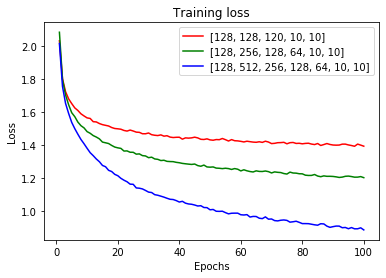

In [22]:
color_list = ['r','g','b']
multi_plot(loss_list, color_list, layer_list)

### 2. activation function (except the activation for last layer): relu, leaky_relu

In [24]:
n_input_training, n_class, layers_init, epochs_init, learning_rate_init, weight_decay_init,\
batch_size_init, dropout_ratio_init, optimizer, activation_init = inital_param()

activation_list = ['relu', 'leaky_relu']

## set the layer as [512, 256, 128, 64, 10]
layer = [512, 256, 128, 64, 10]

loss_list, trian_pre_list, trian_rec_list, test_pre_list, test_rec_list, f1_test_list, f1_train_list, \
    acc_test_list, acc_train_list = need_list()
for i in activation_list:
    activation = i
    nn = MLP(n_input_training, n_class, layer, optimizer, activation = activation, activation_last_layer = 'softmax',
                 dropout_ratio = dropout_ratio_init, is_batch_normalization = True)
    loss = nn.fit(x_train_norm, train_label,learning_rate = learning_rate_init,
              epochs = epochs_init, batch_size = batch_size_init, weight_decay = weight_decay_init)
    
    loss_list, trian_pre_list, trian_rec_list, test_pre_list, test_rec_list, f1_test_list, \
    f1_train_list, acc_test_list, acc_train_list = append_list(loss, nn)
    print(trian_pre_list)
    

Epoch: 5, loss: 1.54040, train_acc: 0.46, time(s): 11.19
Epoch: 10, loss: 1.37676, train_acc: 0.53, time(s): 11.38
Epoch: 15, loss: 1.27448, train_acc: 0.57, time(s): 11.17
Epoch: 20, loss: 1.20837, train_acc: 0.59, time(s): 11.08
Epoch: 25, loss: 1.15318, train_acc: 0.61, time(s): 11.14
Epoch: 30, loss: 1.11372, train_acc: 0.62, time(s): 11.35
Epoch: 35, loss: 1.07960, train_acc: 0.64, time(s): 11.33
Epoch: 40, loss: 1.04871, train_acc: 0.65, time(s): 11.34
Epoch: 45, loss: 1.03529, train_acc: 0.65, time(s): 11.41
Epoch: 50, loss: 1.00804, train_acc: 0.66, time(s): 11.28
Epoch: 55, loss: 0.98585, train_acc: 0.67, time(s): 11.55
Epoch: 60, loss: 0.96705, train_acc: 0.67, time(s): 11.38
Epoch: 65, loss: 0.96170, train_acc: 0.68, time(s): 11.38
Epoch: 70, loss: 0.93231, train_acc: 0.69, time(s): 11.33
Epoch: 75, loss: 0.92725, train_acc: 0.69, time(s): 11.70
Epoch: 80, loss: 0.91226, train_acc: 0.69, time(s): 11.38
Epoch: 85, loss: 0.89780, train_acc: 0.70, time(s): 11.58
Epoch: 90, loss

In [25]:
activation_eval = [trian_pre_list,trian_rec_list, test_pre_list, test_rec_list, f1_test_list, \
    f1_train_list, acc_test_list, acc_train_list]
activation_df = pd.DataFrame(activation_eval, columns = ['evaluation','relu','leaky relu'])
activation_df

,evaluation,relu,leaky relu
0,train percision,0.749,0.232
1,train recall,0.737,0.236
2,test percision,0.468,0.230
3,test recall,0.459,0.237
4,test f1 score,0.460,0.220
5,train f1 score,0.740,0.220
6,test accuracy,0.460,0.237
7,train accuracy,0.737,0.236


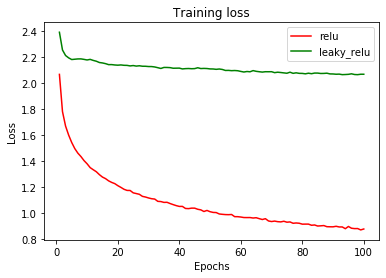

In [26]:
color_list = ['r','g']
multi_plot(loss_list, color_list, activation_list)

### 3+4. learning rate: 0.002, 0.001, 0.005 (intial = 0.002) with batch size: 50, 100, 500 (intial = 100)

In [28]:
n_input_training, n_class, layers_init, epochs_init, learning_rate_init, weight_decay_init,\
batch_size_init, dropout_ratio_init, optimizer, activation_init = inital_param()

## set the layers as  [512, 256, 128, 64, 10]
layer = [512, 256, 128, 64, 10]

## set the activiation function as relu
activiation = 'relu'

# selective between [0.01 - 0.001]
lr_list = [0.01, 0.002, 0.001]

batch_list = [50, 100, 500]

loss_list, trian_pre_list, trian_rec_list, test_pre_list, test_rec_list, f1_test_list, f1_train_list, \
    acc_test_list, acc_train_list = need_list()

for j in batch_list:
    batch_size = j
    for i in lr_list:
        learning_rate = i
        nn = MLP(n_input_training, n_class, layer, optimizer, activation = activiation, activation_last_layer = 'softmax',
                     dropout_ratio = dropout_ratio_init, is_batch_normalization = True)
        loss = nn.fit(x_train_norm, train_label,learning_rate = learning_rate,
                  epochs = epochs_init, batch_size = batch_size, weight_decay = weight_decay_init)

        loss_list, trian_pre_list, trian_rec_list, test_pre_list, test_rec_list, f1_test_list, \
        f1_train_list, acc_test_list, acc_train_list = append_list(loss, nn)
    
print(trian_pre_list)


Epoch: 5, loss: 1.59785, train_acc: 0.43, time(s): 17.06
Epoch: 10, loss: 1.46239, train_acc: 0.49, time(s): 23.50
Epoch: 15, loss: 1.39365, train_acc: 0.52, time(s): 25.05
Epoch: 20, loss: 1.33602, train_acc: 0.54, time(s): 25.40
Epoch: 25, loss: 1.30985, train_acc: 0.55, time(s): 25.42
Epoch: 30, loss: 1.27629, train_acc: 0.56, time(s): 25.21
Epoch: 35, loss: 1.24229, train_acc: 0.58, time(s): 25.46
Epoch: 40, loss: 1.22011, train_acc: 0.58, time(s): 25.32
Epoch: 45, loss: 1.21117, train_acc: 0.59, time(s): 25.34
Epoch: 50, loss: 1.19448, train_acc: 0.60, time(s): 25.51
Epoch: 55, loss: 1.17723, train_acc: 0.60, time(s): 25.73
Epoch: 60, loss: 1.15731, train_acc: 0.61, time(s): 25.15
Epoch: 65, loss: 1.15034, train_acc: 0.61, time(s): 25.56
Epoch: 70, loss: 1.14353, train_acc: 0.61, time(s): 24.95
Epoch: 75, loss: 1.13428, train_acc: 0.62, time(s): 25.36
Epoch: 80, loss: 1.11904, train_acc: 0.63, time(s): 25.62
Epoch: 85, loss: 1.10891, train_acc: 0.63, time(s): 25.46
Epoch: 90, loss

Epoch: 70, loss: 1.77883, train_acc: 0.33, time(s): 10.47
Epoch: 75, loss: 1.76803, train_acc: 0.34, time(s): 10.49
Epoch: 80, loss: 1.76343, train_acc: 0.34, time(s): 10.89
Epoch: 85, loss: 1.75720, train_acc: 0.34, time(s): 11.04
Epoch: 90, loss: 1.75168, train_acc: 0.34, time(s): 11.11
Epoch: 95, loss: 1.74792, train_acc: 0.35, time(s): 11.22
Epoch: 100, loss: 1.74340, train_acc: 0.35, time(s): 11.35
loss: 1.87394, test_acc: 0.35, time(s): 7.11
loss: 1.86786, test_acc: 0.30, time(s): 1.49
Epoch: 5, loss: 2.32001, train_acc: 0.10, time(s): 10.43
Epoch: 10, loss: 2.19252, train_acc: 0.16, time(s): 10.17
Epoch: 15, loss: 2.06636, train_acc: 0.18, time(s): 10.32
Epoch: 20, loss: 2.00288, train_acc: 0.21, time(s): 10.31
Epoch: 25, loss: 1.96083, train_acc: 0.24, time(s): 10.75
Epoch: 30, loss: 1.93868, train_acc: 0.24, time(s): 10.27
Epoch: 35, loss: 1.93101, train_acc: 0.24, time(s): 10.51
Epoch: 40, loss: 1.92299, train_acc: 0.25, time(s): 10.57
Epoch: 45, loss: 1.91394, train_acc: 0.2

In [29]:
lr_eval = [trian_pre_list,trian_rec_list, test_pre_list, test_rec_list, f1_test_list, \
    f1_train_list, acc_test_list, acc_train_list]
lr_df = pd.DataFrame(lr_eval, columns = ['evaluation','50 & 0.01','50 & 0.002','50 & 0.001',\
                                         '100 & 0.01','100 & 0.002','100 & 0.001',\
                                        '500 & 0.01','500 & 0.002','500 & 0.001'])
lr_df

,evaluation,50 & 0.01,50 & 0.002,50 & 0.001,100 & 0.01,100 & 0.002,100 & 0.001,500 & 0.01,500 & 0.002,500 & 0.001
0,train percision,0.695,0.539,0.484,0.446,0.430,0.395,0.335,0.264,0.242
1,train recall,0.677,0.531,0.480,0.441,0.420,0.398,0.355,0.285,0.258
2,test percision,0.474,0.438,0.415,0.385,0.367,0.337,0.284,0.239,0.219
3,test recall,0.462,0.434,0.414,0.380,0.358,0.341,0.303,0.261,0.235
4,test f1 score,0.470,0.440,0.410,0.370,0.360,0.330,0.280,0.230,0.210
5,train f1 score,0.680,0.530,0.480,0.430,0.420,0.390,0.330,0.250,0.230
6,test accuracy,0.462,0.434,0.414,0.380,0.358,0.341,0.303,0.261,0.235
7,train accuracy,0.677,0.531,0.481,0.441,0.420,0.398,0.355,0.284,0.258


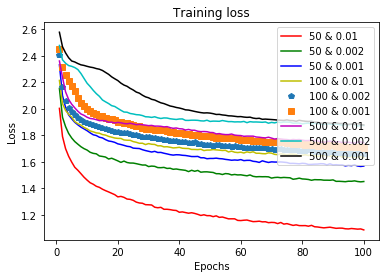

In [33]:
Blr_list = ['50 & 0.01','50 & 0.002','50 & 0.001',\
                                         '100 & 0.01','100 & 0.002','100 & 0.001',\
                                        '500 & 0.01','500 & 0.002','500 & 0.001']
color_list = ['r','g','b','y','p','s','m','c','k']
multi_plot(loss_list, color_list, Blr_list)

### 5. Dropout ratio: 0.2， 0.3，0.5 (intial = 0.2)

In [19]:
n_input_training, n_class, layers_init, epochs_init, learning_rate_init, weight_decay_init,\
batch_size_init, dropout_ratio_init, optimizer, activation_init = inital_param()

## set the layers as  [512, 256, 128, 64, 10]
layer = [512, 256, 128, 64, 10]

## set the activiation function as relu
activiation = 'relu'

## set the batch size as  50
batch_size = 50

## set the learning rate to 0.01
lr = 0.01

dpout_list = [0.2, 0.3, 0.5]

loss_list, trian_pre_list, trian_rec_list, test_pre_list, test_rec_list, f1_test_list, f1_train_list, \
    acc_test_list, acc_train_list = need_list()

for i in dpout_list:
    dropout_ratio = i
    nn = MLP(n_input_training, n_class, layer, optimizer, activation = activiation, activation_last_layer = 'softmax',
                 dropout_ratio = dropout_ratio, is_batch_normalization = True)
    loss = nn.fit(x_train_norm, train_label,learning_rate = lr,
              epochs = epochs_init, batch_size = batch_size, weight_decay = weight_decay_init)
    
    loss_list, trian_pre_list, trian_rec_list, test_pre_list, test_rec_list, f1_test_list, \
    f1_train_list, acc_test_list, acc_train_list = append_list(loss, nn)
    
print(trian_pre_list)

Epoch: 5, loss: 1.58166, train_acc: 0.45, time(s): 17.37
Epoch: 10, loss: 1.45575, train_acc: 0.50, time(s): 23.95
Epoch: 15, loss: 1.39722, train_acc: 0.52, time(s): 25.88
Epoch: 20, loss: 1.33896, train_acc: 0.54, time(s): 25.56
Epoch: 25, loss: 1.28973, train_acc: 0.56, time(s): 26.32
Epoch: 30, loss: 1.26548, train_acc: 0.57, time(s): 25.94
Epoch: 35, loss: 1.24318, train_acc: 0.58, time(s): 26.27
Epoch: 40, loss: 1.21952, train_acc: 0.59, time(s): 26.41
Epoch: 45, loss: 1.20204, train_acc: 0.59, time(s): 25.88
Epoch: 50, loss: 1.18689, train_acc: 0.60, time(s): 25.68
Epoch: 55, loss: 1.17053, train_acc: 0.60, time(s): 25.51
Epoch: 60, loss: 1.16048, train_acc: 0.61, time(s): 25.57
Epoch: 65, loss: 1.13615, train_acc: 0.61, time(s): 25.49
Epoch: 70, loss: 1.13236, train_acc: 0.62, time(s): 25.36
Epoch: 75, loss: 1.12635, train_acc: 0.62, time(s): 25.62
Epoch: 80, loss: 1.12194, train_acc: 0.62, time(s): 25.52
Epoch: 85, loss: 1.10817, train_acc: 0.63, time(s): 26.00
Epoch: 90, loss

In [20]:
drop_eval = [trian_pre_list,trian_rec_list, test_pre_list, test_rec_list, f1_test_list, \
    f1_train_list, acc_test_list, acc_train_list]
drop_df = pd.DataFrame(drop_eval, columns = ['evaluation','0.2','0.3', '0.5'])
drop_df

,evaluation,0.2,0.3,0.5
0,train percision,0.700,0.397,0.185
1,train recall,0.698,0.390,0.181
2,test percision,0.474,0.348,0.178
3,test recall,0.474,0.343,0.174
4,test f1 score,0.470,0.340,0.160
5,train f1 score,0.700,0.390,0.160
6,test accuracy,0.474,0.343,0.174
7,train accuracy,0.699,0.389,0.181


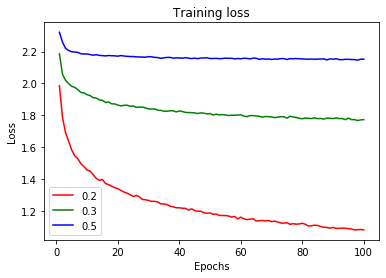

In [21]:
color_list = ['r','g','b']
multi_plot(loss_list, color_list, dpout_list)

### 6. optimizer

In [19]:
n_input_training, n_class, layers_init, epochs_init, learning_rate_init, weight_decay_init,\
batch_size_init, dropout_ratio_init, optimizer, activation_init = inital_param()

## set the layers as  [512, 256, 128, 64, 10]
layer = [512, 256, 128, 64, 10]

## set the activiation function as relu
activiation = 'relu'

## set the batch size as  50
batch_size = 50

## set the learning rate to 0.01
lr = 0.01

## set the dropout ratio to 0.2
DropOut = 0.2

opt_list = ['Adam','Adagrad','RMSprop','SGD','Momentum']

loss_list, trian_pre_list, trian_rec_list, test_pre_list, test_rec_list, f1_test_list, f1_train_list, \
    acc_test_list, acc_train_list = need_list()

for i in opt_list:
    opt = i
    nn = MLP(n_input_training, n_class, layer, opt, activation = activiation, activation_last_layer = 'softmax',
                 dropout_ratio = DropOut, is_batch_normalization = True)
    loss = nn.fit(x_train_norm, train_label,learning_rate = lr,
              epochs = epochs_init, batch_size = batch_size, weight_decay = weight_decay_init)
    
    loss_list, trian_pre_list, trian_rec_list, test_pre_list, test_rec_list, f1_test_list, \
    f1_train_list, acc_test_list, acc_train_list = append_list(loss, nn)
    
print(trian_pre_list)

Epoch: 5, loss: 1.58741, train_acc: 0.44, time(s): 22.33
Epoch: 10, loss: 1.46055, train_acc: 0.49, time(s): 29.52
Epoch: 15, loss: 1.39050, train_acc: 0.52, time(s): 30.63
Epoch: 20, loss: 1.34075, train_acc: 0.54, time(s): 30.34
Epoch: 25, loss: 1.29335, train_acc: 0.56, time(s): 30.75
Epoch: 30, loss: 1.26795, train_acc: 0.57, time(s): 24.32
Epoch: 35, loss: 1.24057, train_acc: 0.58, time(s): 24.70
Epoch: 40, loss: 1.21742, train_acc: 0.58, time(s): 24.69
Epoch: 45, loss: 1.19630, train_acc: 0.60, time(s): 24.81
Epoch: 50, loss: 1.17826, train_acc: 0.60, time(s): 24.48
Epoch: 55, loss: 1.16318, train_acc: 0.61, time(s): 24.55
Epoch: 60, loss: 1.14938, train_acc: 0.61, time(s): 24.27
Epoch: 65, loss: 1.14249, train_acc: 0.61, time(s): 26.07
Epoch: 70, loss: 1.12798, train_acc: 0.62, time(s): 24.98
Epoch: 75, loss: 1.11794, train_acc: 0.62, time(s): 25.35
Epoch: 80, loss: 1.10913, train_acc: 0.62, time(s): 24.88
Epoch: 85, loss: 1.09418, train_acc: 0.63, time(s): 25.49
Epoch: 90, loss

In [ ]:
opt_eval = [trian_pre_list,trian_rec_list, test_pre_list, test_rec_list, f1_test_list, \
    f1_train_list, acc_test_list, acc_train_list]
opt_df = pd.DataFrame(opt_eval, columns = ['evaluation','Adam','Adagrad','RMSprop','SGD','Momentum'])
opt_df

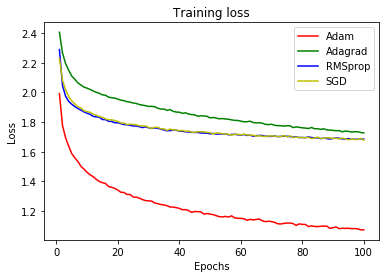

In [21]:
color_list = ['r','g','b','y']
multi_plot(loss_list, color_list, opt_list)

## Ablation study

1. Batch Normalization
2. Drop out
3. Weight decay

### 1. Batch Normalization

In [26]:
n_input_training, n_class, layers_init, epochs_init, learning_rate_init, weight_decay_init,\
batch_size_init, dropout_ratio_init, optimizer, activation_init = inital_param()

## set the layers as  [512, 256, 128, 64, 10]
layer = [512, 256, 128, 64, 10]

## set the activiation function as relu
activiation = 'relu'

## set the batch size as  50
batch_size = 50

## set the learning rate to 0.01
lr = 0.01

## set the dropout ratio to 0.2
DropOut = 0.2

## set the optimizer
opt = 'Adam'


BN_list = [True, False]

loss_list, trian_pre_list, trian_rec_list, test_pre_list, test_rec_list, f1_test_list, f1_train_list, \
    acc_test_list, acc_train_list = need_list()

for i in BN_list:
    BN = i
    nn = MLP(n_input_training, n_class, layer, opt, activation = activiation, activation_last_layer = 'softmax',
                 dropout_ratio = DropOut, is_batch_normalization = BN)
    loss = nn.fit(x_train_norm, train_label,learning_rate = learning_rate_init,
              epochs = epochs_init, batch_size = batch_size, weight_decay = weight_decay_init)
    
    loss_list, trian_pre_list, trian_rec_list, test_pre_list, test_rec_list, f1_test_list, \
    f1_train_list, acc_test_list, acc_train_list = append_list(loss, nn)
    
print(trian_pre_list)

Epoch: 5, loss: 1.56913, train_acc: 0.46, time(s): 17.30
Epoch: 10, loss: 1.43240, train_acc: 0.51, time(s): 17.65
Epoch: 15, loss: 1.34473, train_acc: 0.54, time(s): 18.19
Epoch: 20, loss: 1.28599, train_acc: 0.56, time(s): 18.18
Epoch: 25, loss: 1.24963, train_acc: 0.58, time(s): 18.50
Epoch: 30, loss: 1.21630, train_acc: 0.59, time(s): 18.66
Epoch: 35, loss: 1.18629, train_acc: 0.60, time(s): 18.54
Epoch: 40, loss: 1.16155, train_acc: 0.61, time(s): 19.01
Epoch: 45, loss: 1.14066, train_acc: 0.62, time(s): 17.25
Epoch: 50, loss: 1.12053, train_acc: 0.62, time(s): 18.68
Epoch: 55, loss: 1.09996, train_acc: 0.63, time(s): 18.02
Epoch: 60, loss: 1.09190, train_acc: 0.63, time(s): 19.64
Epoch: 65, loss: 1.07222, train_acc: 0.64, time(s): 17.89
Epoch: 70, loss: 1.06259, train_acc: 0.64, time(s): 17.86
Epoch: 75, loss: 1.05391, train_acc: 0.65, time(s): 18.89
Epoch: 80, loss: 1.04163, train_acc: 0.65, time(s): 17.95
Epoch: 85, loss: 1.03415, train_acc: 0.65, time(s): 17.50
Epoch: 90, loss

In [27]:
BN_eval = [trian_pre_list,trian_rec_list, test_pre_list, test_rec_list, f1_test_list, \
    f1_train_list, acc_test_list, acc_train_list]
BN_df = pd.DataFrame(BN_eval, columns = ['evaluation','True','False'])
BN_df

,evaluation,True,False
0,train percision,0.727,0.194
1,train recall,0.716,0.219
2,test percision,0.472,0.185
3,test recall,0.463,0.209
4,test f1 score,0.460,0.160
5,train f1 score,0.720,0.160
6,test accuracy,0.463,0.209
7,train accuracy,0.716,0.219


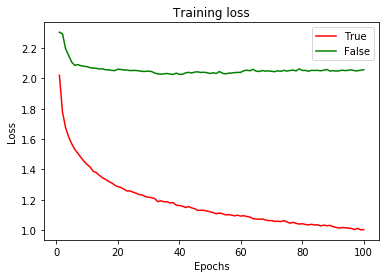

In [28]:
color_list = ['r','g']
multi_plot(loss_list, color_list, BN_list)

### 2. Drop out

In [30]:
n_input_training, n_class, layers_init, epochs_init, learning_rate_init, weight_decay_init,\
batch_size_init, dropout_ratio_init, optimizer, activation_init = inital_param()

## set the layers as  [512, 256, 128, 64, 10]
layer = [512, 256, 128, 64, 10]

## set the activiation function as relu
activiation = 'relu'

## set the batch size as  50
batch_size = 50

## set the learning rate to 0.01
lr = 0.01

## set the optimizer
opt = 'Adam'

DO_list = [0.2, 0]

loss_list, trian_pre_list, trian_rec_list, test_pre_list, test_rec_list, f1_test_list, f1_train_list, \
    acc_test_list, acc_train_list = need_list()

for i in DO_list:
    DO = i
    nn = MLP(n_input_training, n_class, layer, opt, activation = activiation, activation_last_layer = 'softmax',
                 dropout_ratio = DO, is_batch_normalization = True)
    loss = nn.fit(x_train_norm, train_label,learning_rate = lr,
              epochs = epochs_init, batch_size = batch_size, weight_decay = weight_decay_init)
    
    loss_list, trian_pre_list, trian_rec_list, test_pre_list, test_rec_list, f1_test_list, \
    f1_train_list, acc_test_list, acc_train_list = append_list(loss, nn)
    
print(trian_pre_list)

Epoch: 5, loss: 1.57846, train_acc: 0.44, time(s): 19.57
Epoch: 10, loss: 1.45050, train_acc: 0.49, time(s): 23.80
Epoch: 15, loss: 1.37776, train_acc: 0.52, time(s): 26.04
Epoch: 20, loss: 1.32747, train_acc: 0.54, time(s): 24.69
Epoch: 25, loss: 1.29107, train_acc: 0.56, time(s): 25.61
Epoch: 30, loss: 1.25441, train_acc: 0.57, time(s): 24.38
Epoch: 35, loss: 1.23125, train_acc: 0.58, time(s): 24.36
Epoch: 40, loss: 1.20791, train_acc: 0.59, time(s): 23.77
Epoch: 45, loss: 1.18706, train_acc: 0.60, time(s): 23.91
Epoch: 50, loss: 1.17832, train_acc: 0.60, time(s): 24.96
Epoch: 55, loss: 1.15772, train_acc: 0.60, time(s): 24.30
Epoch: 60, loss: 1.15156, train_acc: 0.61, time(s): 24.69
Epoch: 65, loss: 1.13802, train_acc: 0.61, time(s): 27.99
Epoch: 70, loss: 1.11385, train_acc: 0.62, time(s): 26.58
Epoch: 75, loss: 1.11533, train_acc: 0.62, time(s): 24.94
Epoch: 80, loss: 1.10917, train_acc: 0.62, time(s): 25.14
Epoch: 85, loss: 1.09182, train_acc: 0.63, time(s): 24.74
Epoch: 90, loss

In [31]:
DO_eval = [trian_pre_list,trian_rec_list, test_pre_list, test_rec_list, f1_test_list, \
    f1_train_list, acc_test_list, acc_train_list]
DO_df = pd.DataFrame(DO_eval, columns = ['evaluation','0.2','0'])
DO_df

,evaluation,0.2,0
0,train percision,0.702,0.986
1,train recall,0.681,0.986
2,test percision,0.476,0.510
3,test recall,0.460,0.507
4,test f1 score,0.460,0.510
5,train f1 score,0.690,0.980
6,test accuracy,0.460,0.507
7,train accuracy,0.681,0.986


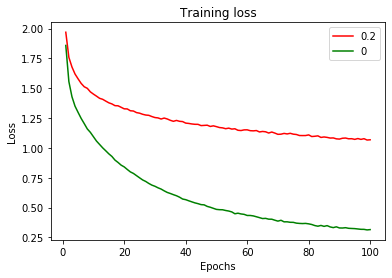

In [32]:
color_list = ['r','g']
multi_plot(loss_list, color_list, DO_list)

### 3. weight decay

In [ ]:
n_input_training, n_class, layers_init, epochs_init, learning_rate_init, weight_decay_init,\
batch_size_init, dropout_ratio_init, optimizer, activation_init = inital_param()

## set the layers as  [512, 256, 128, 64, 10]
layer = [512, 256, 128, 64, 10]

## set the activiation function as relu
activiation = 'relu'

## set the batch size as  50
batch_size = 50

## set the learning rate to 0.01
lr = 0.01

## set the dropout ratio to 0.2
DropOut = 0.2

## set the optimizer
opt = 'Adam'

weightD_list = [0.98, 1]

loss_list, trian_pre_list, trian_rec_list, test_pre_list, test_rec_list, f1_test_list, f1_train_list, \
    acc_test_list, acc_train_list = need_list()

for i in weightD_list:
    wd = i
    nn = MLP(n_input_training, n_class, layer, opt, activation = activiation, activation_last_layer = 'softmax',
                 dropout_ratio = DropOut, is_batch_normalization = True)
    loss = nn.fit(x_train_norm, train_label,learning_rate = lr,
              epochs = epochs_init, batch_size = batch_size, weight_decay = wd)
    
    loss_list, trian_pre_list, trian_rec_list, test_pre_list, test_rec_list, f1_test_list, \
    f1_train_list, acc_test_list, acc_train_list = append_list(loss, nn)
    
print(trian_pre_list)

In [ ]:
wd_eval = [trian_pre_list,trian_rec_list, test_pre_list, test_rec_list, f1_test_list, \
    f1_train_list, acc_test_list, acc_train_list]
wd_df = pd.DataFrame(wd_eval, columns = ['evaluation','0.98','1'])
wd_df

## Best Model

According to the study of the value of hyperparameters, we decided to select the value with highest test accuracy in each hyperparameters comparsion.

##### Therefore our best model is:
Activiation function: Relu；
Learning Rate: 0.01；
Layer: 5 layers -- [512,256,128,64,10]；
Dropout Ratio: 0.2；
Batch Size: 50；
Epoch: 100；
WeightDecay: 1；
Optimizer: Adam


In [ ]:
## append the results of each hyperparameter into corresponding list
def append_list1(loss,nn):
    loss_list.append(loss)

    train_loss, train_pred = nn.predict(x_train_norm, train_label)
    test_loss, test_pred = nn.predict(x_test_norm,test_label)
    
    train_analysis = Analysis(train_label, train_pred)
    test_analysis = Analysis(test_label, test_pred)

    trian_pre = train_analysis.precision['macro avg']
    trian_pre_list.append(trian_pre)

    trian_rec = train_analysis.recall['macro avg']
    trian_rec_list.append(trian_rec)

    test_pre = test_analysis.precision['macro avg']
    test_pre_list.append(test_pre)

    test_rec = test_analysis.recall['macro avg']
    test_rec_list.append(test_rec)

    f1_test = test_analysis.f1_score
    f1_test_list.append(f1_test)

    f1_train = train_analysis.f1_score
    f1_train_list.append(f1_train)

    acc_test = test_analysis.accuracy
    acc_test_list.append(acc_test)

    acc_train = train_analysis.accuracy
    acc_train_list.append(acc_train)

    
    return loss_list, trian_pre_list, trian_rec_list, test_pre_list, test_rec_list, f1_test_list, \
    f1_train_list, acc_test_list, acc_train_list


In [ ]:
import time

n_input_training = x_train_norm.shape[1]
n_class = len(np.unique(test_label.reshape(1, -1)))
layers = [512, 256, 128, 64, 10]
epochs = 100
learning_rate = 0.01
weight_decay = 1
batch_size = 50
optimizer = 'Adam'

loss_list, trian_pre_list, trian_rec_list, test_pre_list, test_rec_list, f1_test_list, f1_train_list, \
    acc_test_list, acc_train_list = need_list()

nn = MLP(n_input_training, n_class, layers, optimizer, activation = 'relu', activation_last_layer = 'softmax',
                 dropout_ratio = 0.2, is_batch_normalization = True)
time_start = time.time()
print(time_start)
loss = nn.fit(x_train_norm, train_label,learning_rate = learning_rate,
              epochs = epochs, batch_size = batch_size, weight_decay = weight_decay)
time_end = time.time()
print(time_end)
print("time_cost", time_end-time_start, "s")
loss_list, trian_pre_list, trian_rec_list, test_pre_list, test_rec_list, f1_test_list, \
    f1_train_list, acc_test_list, acc_train_list = append_list1(loss, nn)



In [ ]:
f1_test_list

In [ ]:
best_eval = [trian_pre_list,trian_rec_list, test_pre_list, test_rec_list, acc_test_list, acc_train_list]
best_df = pd.DataFrame(best_eval, columns = ['evaluation','result'])
best_df